# Other Attempt

In [1]:
# Importing libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)
#print(os.listdir("../input"))
import datetime as dt
import missingno as msno
plt.rcParams['figure.dpi'] = 140

In [2]:
from pandas import read_csv
import numpy as np
dataset = read_csv('netflix_titles.csv')

In [3]:
 rating_replacements = {
    5989: 'TV-PG',
    6827: 'TV-14',
    7312: 'TV-MA',
    5541: 'TV-MA',
    5794: 'NR',
    5813: 'TV-MA',
    7537: 'TV-MA'
}

for id, rate in rating_replacements.items():
    dataset.iloc[id, 8] = rate
dataset['rating'].replace({"UR": "NR"}, inplace=True)

In [4]:
dataset.isna().sum() #checking for missing value

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             0
duration           0
listed_in          0
description        0
dtype: int64

In [5]:
dataset['country'] = dataset['country'].fillna(dataset['country'].mode()[0])

In [6]:
# Lets retrieve just the first country
dataset['principal_country'] = dataset['country'].apply(lambda x: x.split(",")[0])
dataset['principal_country'].head()

0    United States
1     South Africa
2    United States
3    United States
4            India
Name: principal_country, dtype: object

In [7]:
dataset.isna().sum()

show_id                 0
type                    0
title                   0
director             2634
cast                  825
country                 0
date_added             10
release_year            0
rating                  0
duration                0
listed_in               0
description             0
principal_country       0
dtype: int64

In [8]:
main_df=dataset
main_df=main_df[main_df["date_added"].notna()]
main_df = main_df.drop(['director', 'cast'], axis=1)
main_df.isna().sum()

show_id              0
type                 0
title                0
country              0
date_added           0
release_year         0
rating               0
duration             0
listed_in            0
description          0
principal_country    0
dtype: int64

In [9]:
main_df['year_added'] = main_df['date_added'].apply(lambda x: x.split(" ")[-1])
main_df['month_added'] = main_df['date_added'].apply(lambda x: x.split(" ")[0])

In [10]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'NC-17': 'Adults'
}

main_df['target_ages'] = main_df['rating'].replace(ratings_ages)
main_df['target_ages'].unique()

array(['Teens', 'Adults', 'Older Kids', 'Kids'], dtype=object)

In [11]:
# type should be a category
main_df['type'] = pd.Categorical(main_df['type'])

# target_ages is another category (4 classes)
main_df['target_ages'] = pd.Categorical(main_df['target_ages'], categories=['Kids', 'Older Kids', 'Teens', 'Adults'])

# Year added should be integer so we can compare with `released_year`
main_df['year_added'] = pd.to_numeric(main_df['year_added'])

In [12]:
main_df.dtypes

show_id                object
type                 category
title                  object
country                object
date_added             object
release_year            int64
rating                 object
duration               object
listed_in              object
description            object
principal_country      object
year_added              int64
month_added            object
target_ages          category
dtype: object

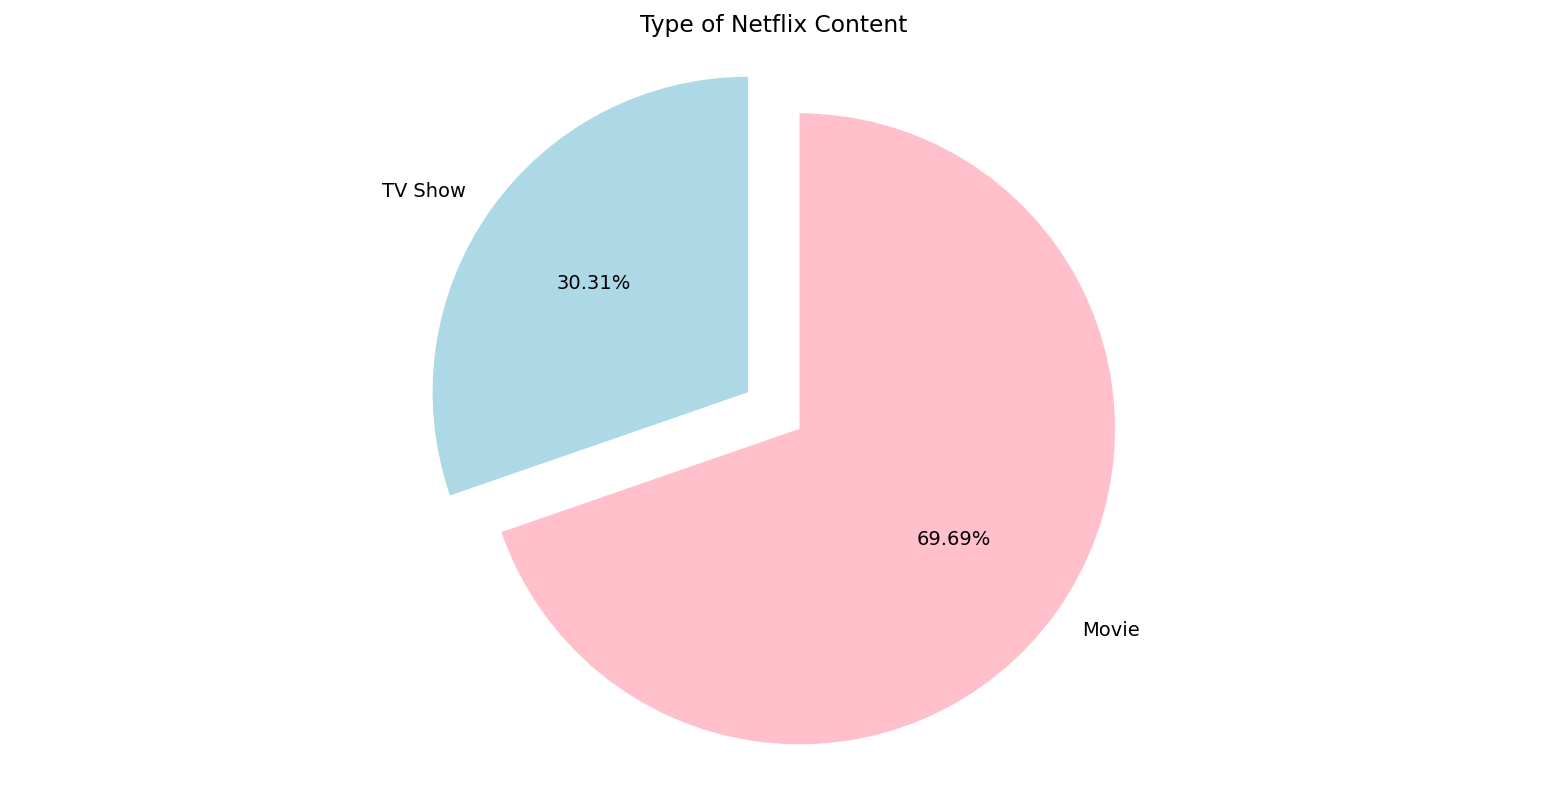

In [13]:
plt.figure(figsize=(14, 7))
labels=['TV Show', 'Movie']
plt.pie(main_df['type'].value_counts().sort_values(),labels=labels,explode=[0.1,0.1],
        autopct='%1.2f%%',colors=['lightblue','pink'], startangle=90)
plt.title('Type of Netflix Content')
plt.axis('equal')
plt.show()
#Nearly 7/10 of the content on netflix are movies while the rest are TV Show

In [14]:
df_tv = main_df[main_df["type"] == "TV Show"]
df_movies = main_df[main_df["type"] == "Movie"]

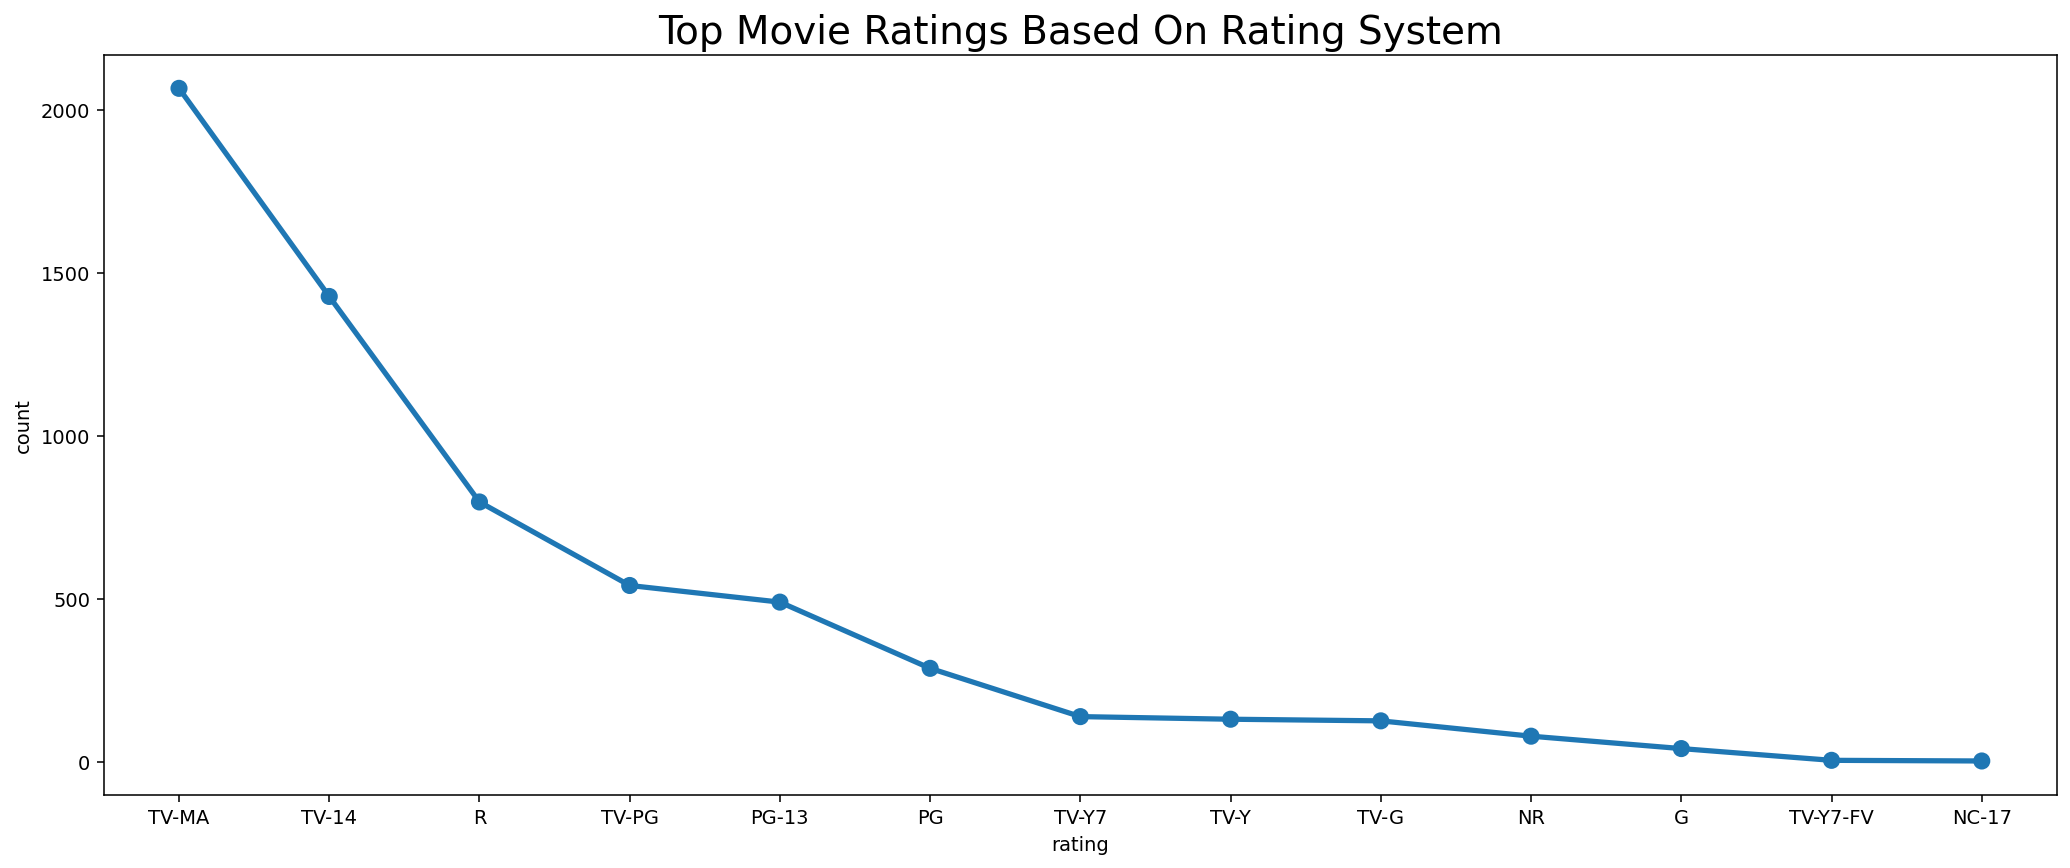

In [15]:
movie_ratings = df_movies.groupby(['rating'])['show_id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
fig_dims = (18,7)
fig, ax = plt.subplots(figsize=fig_dims)  
sns.pointplot(x='rating',y='count',data=movie_ratings)
plt.title('Top Movie Ratings Based On Rating System',size='20')
plt.show()

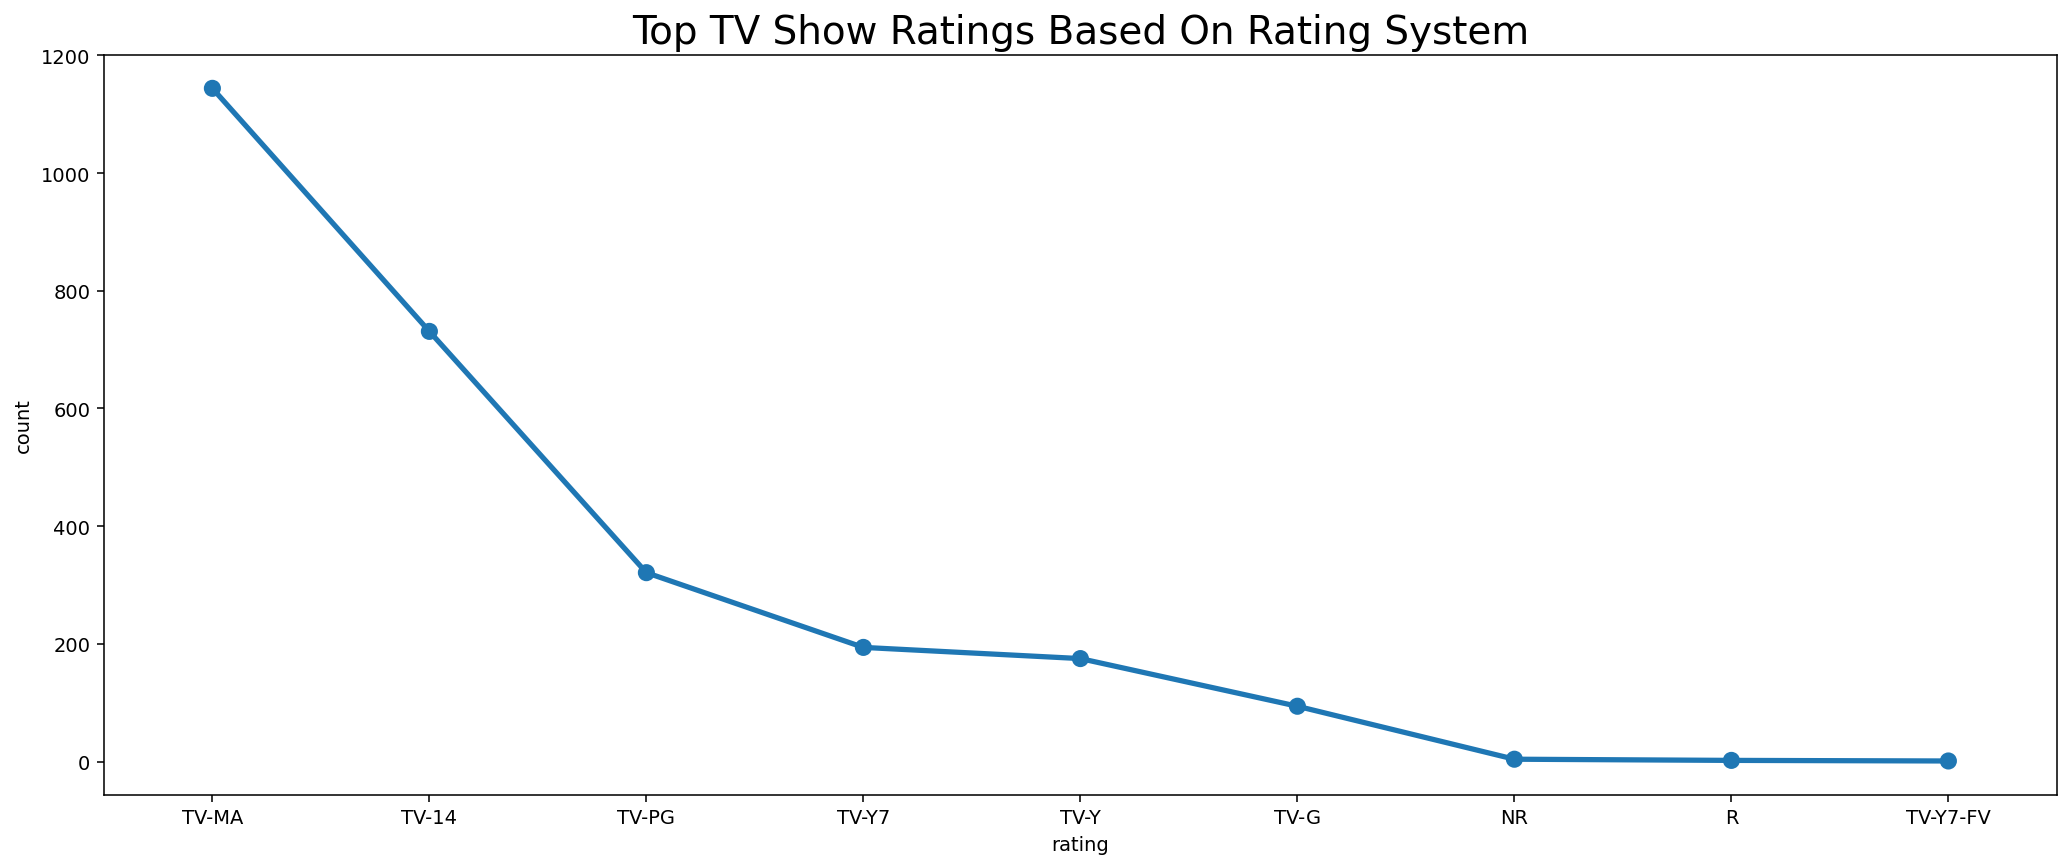

In [16]:
tv_ratings = df_tv.groupby(['rating'])['show_id'].count().reset_index(name='count').sort_values(by='count',ascending=False)
fig_dims = (18,7)
fig, ax = plt.subplots(figsize=fig_dims)  
sns.pointplot(x='rating',y='count',data=tv_ratings)
plt.title('Top TV Show Ratings Based On Rating System',size='20')
plt.show()

In [17]:

def generate_rating_df(main_df):
    rating_df = main_df.groupby(['rating', 'target_ages']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['rating', 'target_ages', 'counts']
    rating_df = rating_df.sort_values('target_ages')
    return rating_df

import plotly.express as px
rating_df = generate_rating_df(main_df)
fig = px.bar(rating_df, x='rating', y='counts', color='target_ages', 
             title='Ratings of Movies And TV Shows Based On Target Age Groups',
             labels={'counts':'COUNT', 'rating':'RATINGS', 'target_ages':'TARGET AGE GROUPS' })
fig.show()

In [18]:
#There's less movies for the kids while more for teens and adults.
#TV Show are more for the kids and teens.

In [19]:
df_content = main_df['year_added'].value_counts().reset_index().rename(columns = {
    'year_added' : 'count', 'index' : 'year_added'}).sort_values('year_added')
df_content['percent'] = df_content['count'].apply(lambda x : 100*x/sum(df_content['count']))


df_tv1 = df_tv['year_added'].value_counts().reset_index().rename(columns = {
    'year_added' : 'count', 'index' : 'year_added'}).sort_values('year_added')
df_tv1['percent'] = df_tv1['count'].apply(lambda x : 100*x/sum(df_tv1['count']))


df_movies1 = df_movies['year_added'].value_counts().reset_index().rename(columns = {
    'year_added' : 'count', 'index' : 'year_added'}).sort_values('year_added')
df_movies1['percent'] = df_movies1['count'].apply(lambda x : 100*x/sum(df_movies1['count']))

In [20]:
t1 = go.Scatter(x=df_movies1['year_added'], y=df_movies1["count"], name="Movies", marker=dict(color="royalblue"))
t2 = go.Scatter(x=df_tv1['year_added'], y=df_tv1["count"], name="TV Shows", marker=dict(color="red"))
t3 = go.Scatter(x=df_content['year_added'], y=df_content["count"], name="Total Contents", marker=dict(color="gold"))

data = [t1, t2, t3]

layout = go.Layout(title="Content added over the years", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

In [21]:
"""The growth in number of movies on netflix is much higher than that of TV shows
About 1200 new movies were added in both 2018 and 2019
The growth in content started from 2013
"""

'The growth in number of movies on netflix is much higher than that of TV shows\nAbout 1200 new movies were added in both 2018 and 2019\nThe growth in content started from 2013\n'

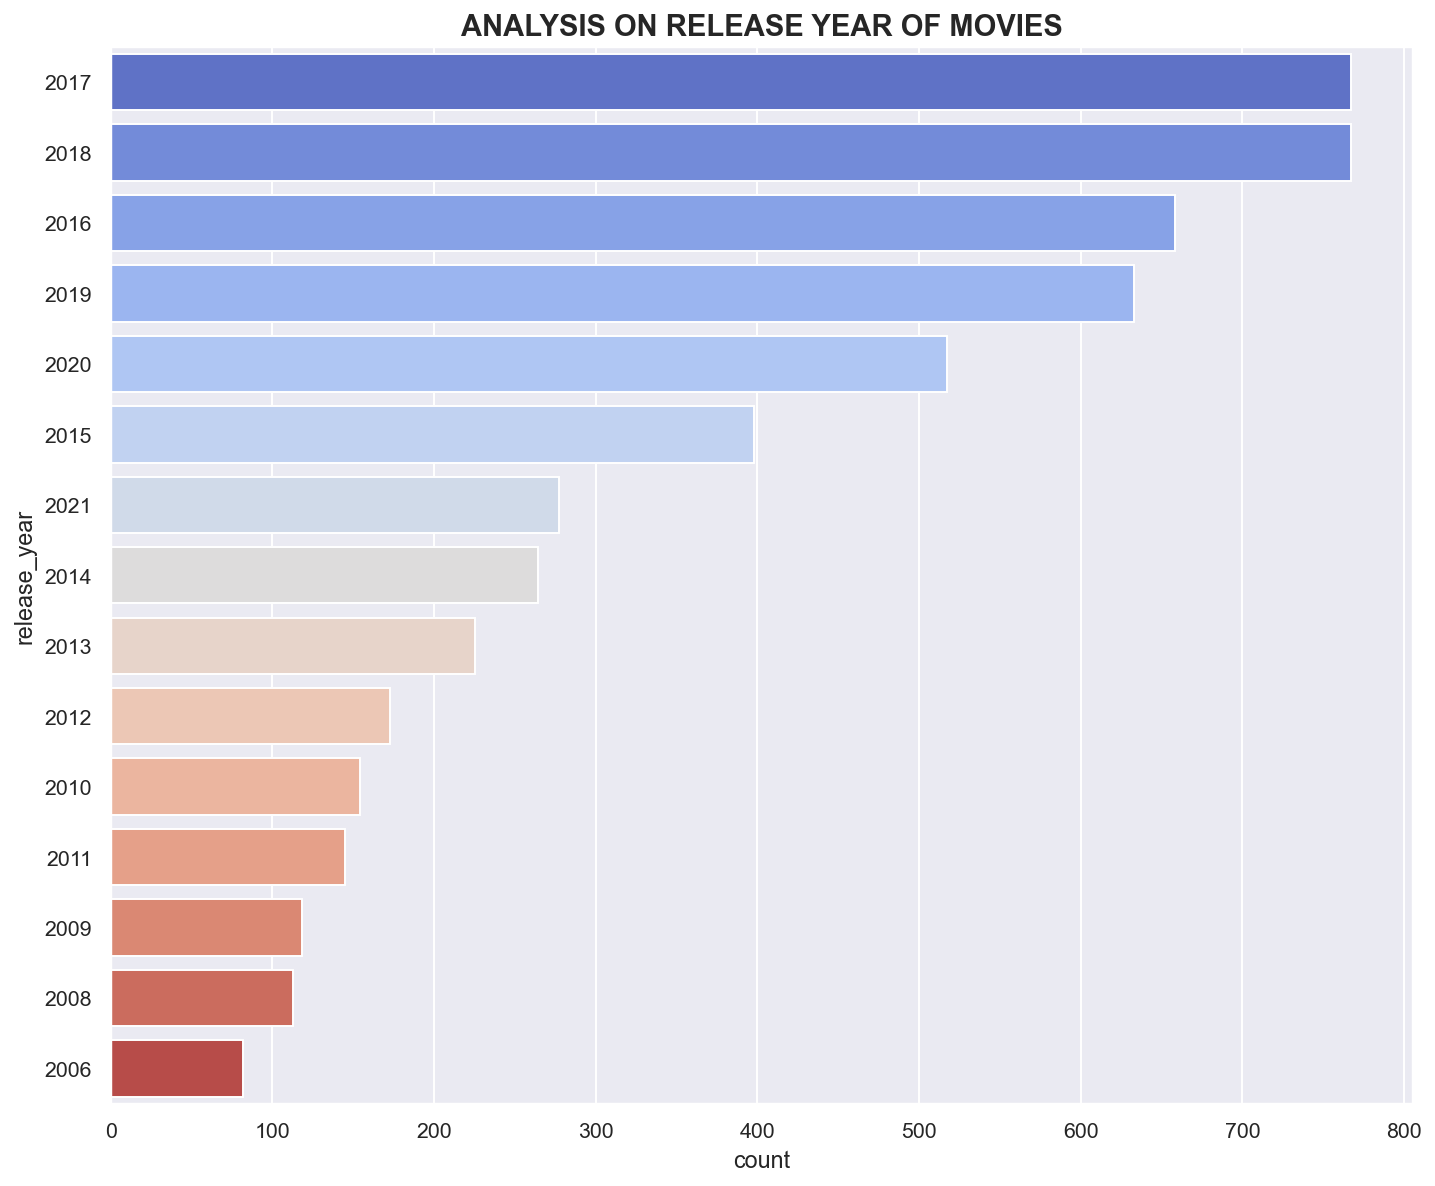

In [22]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=df_movies, palette="coolwarm", order=df_movies['release_year'].value_counts().index[0:15])

plt.title('ANALYSIS ON RELEASE YEAR OF MOVIES', fontsize=15, fontweight='bold')
plt.show()
#Most of the movies were released in the year 2017 & 2018 followed by 2016 and 2019.


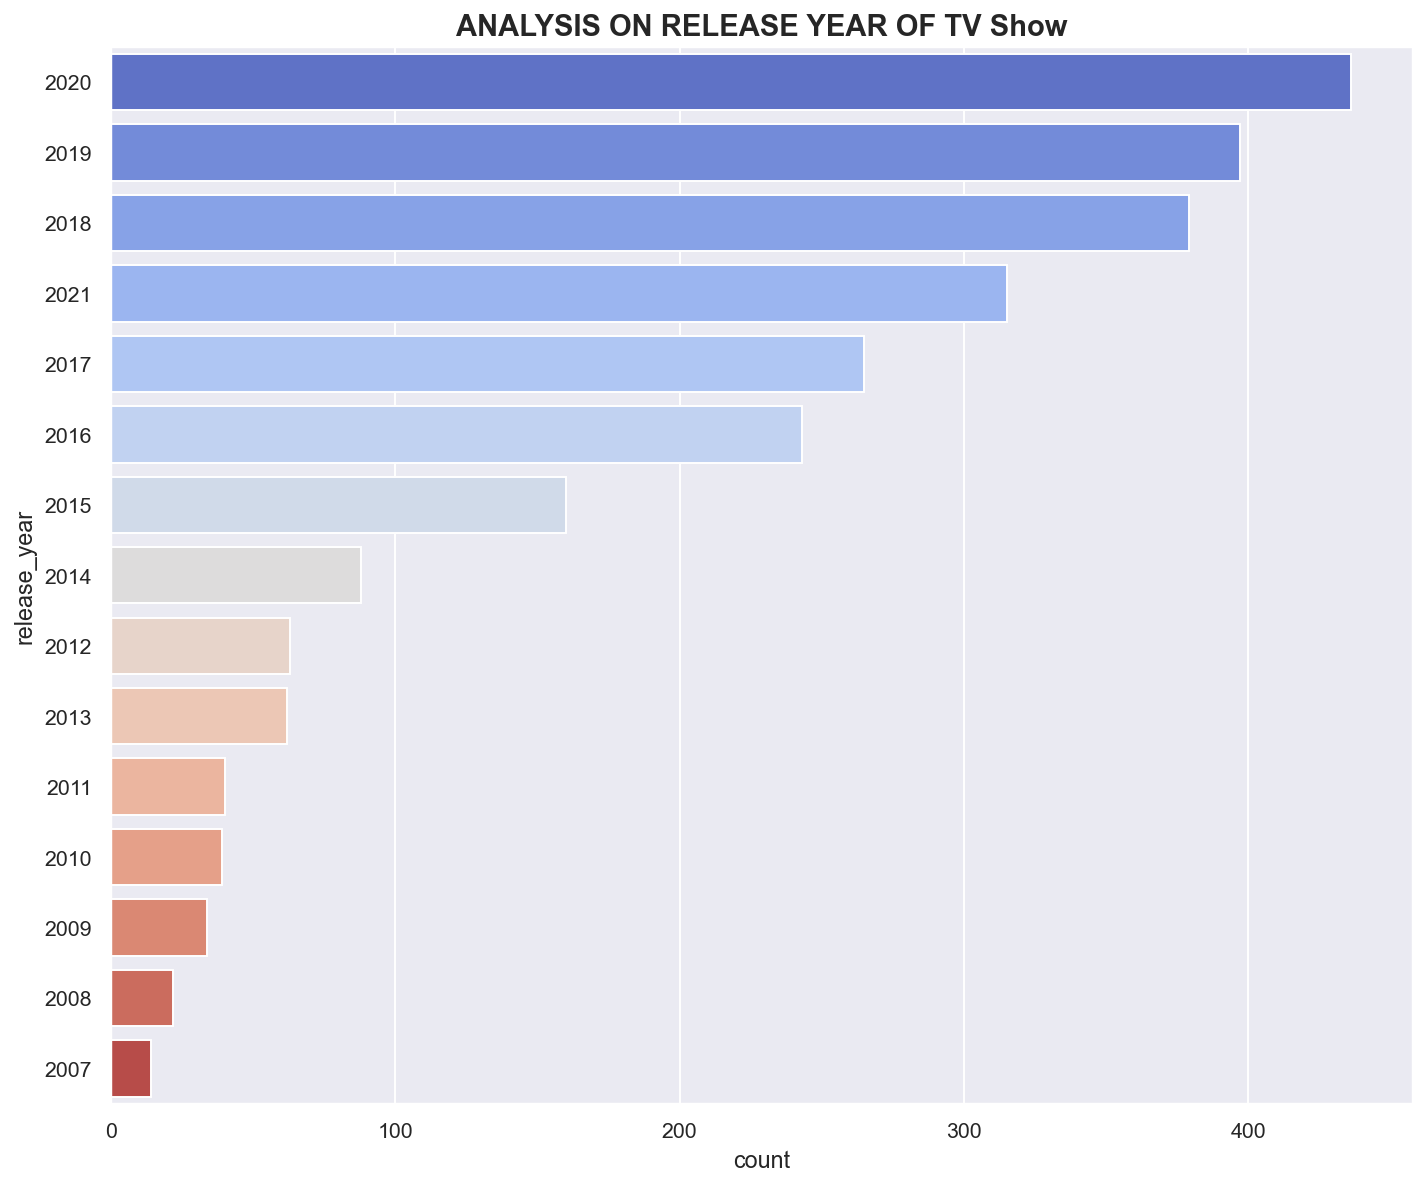

In [23]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=df_tv, palette="coolwarm", order=df_tv['release_year'].value_counts().index[0:15])

plt.title('ANALYSIS ON RELEASE YEAR OF TV Show', fontsize=15, fontweight='bold')
plt.show()
#Most of the TV Shows were released in 2020 followed by 2019 and 2018

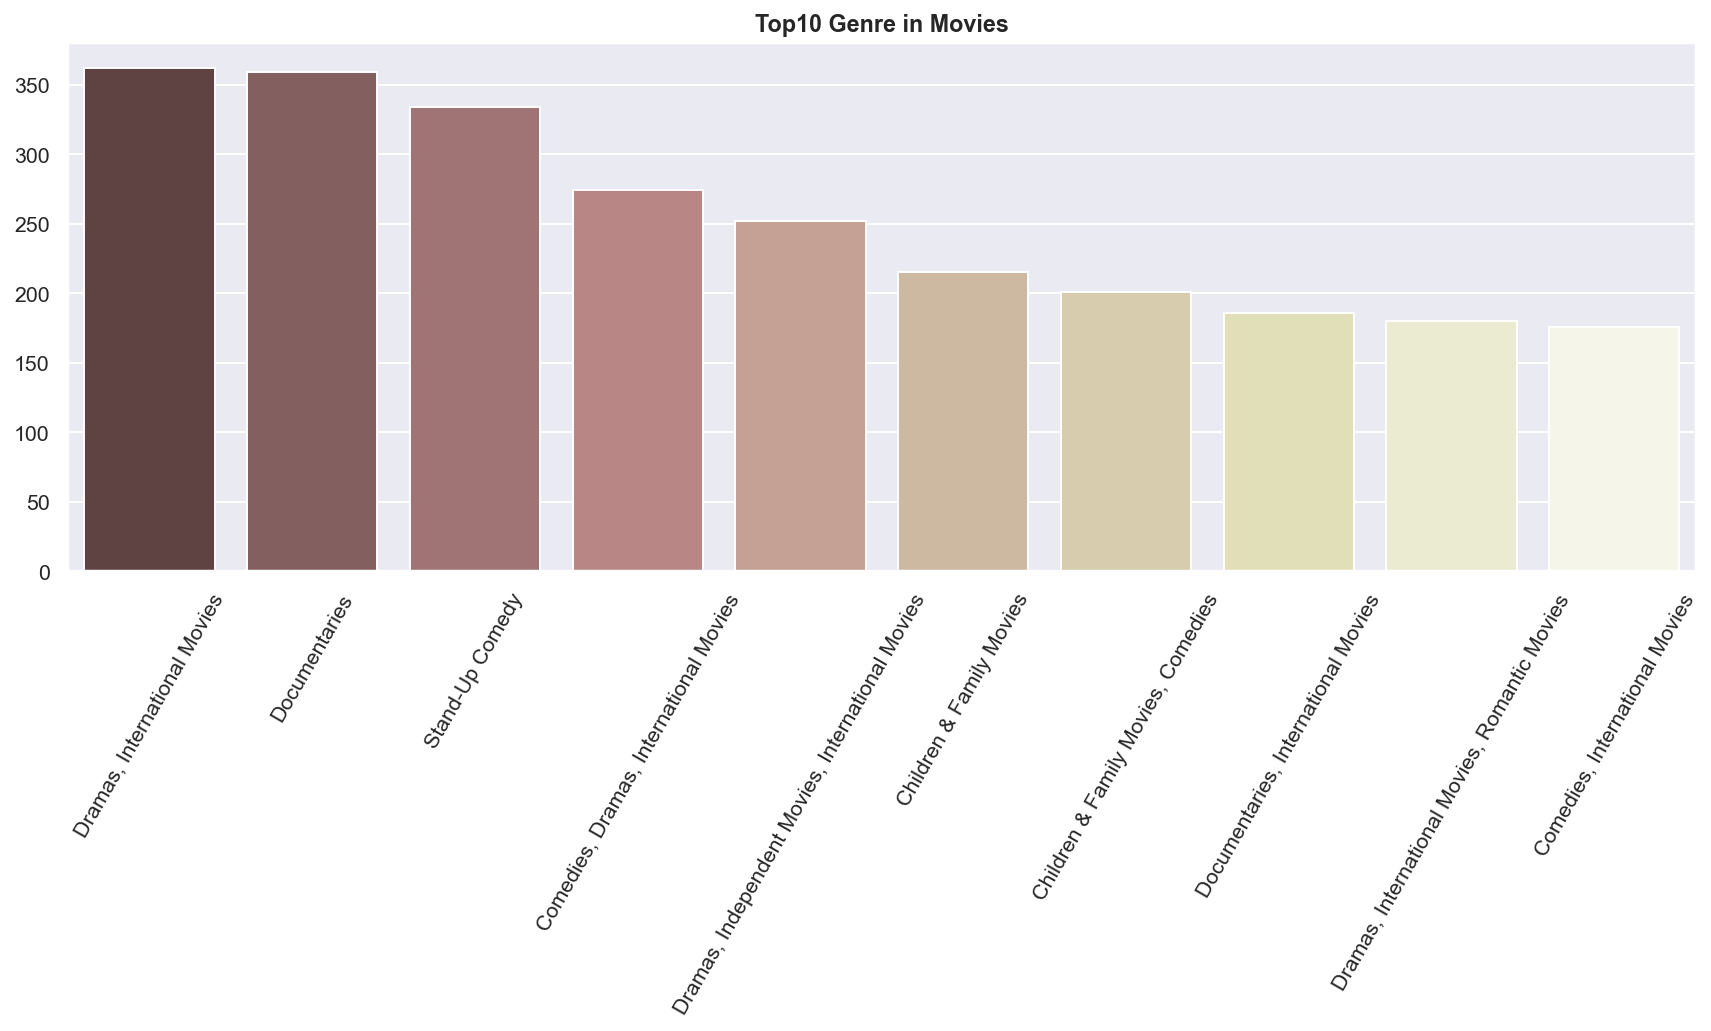

In [24]:
##Top10 Genre in Movies and TV Shows:

plt.figure(figsize=(15,5))
sns.barplot(x = df_movies["listed_in"].value_counts().head(10).index,
            y = df_movies["listed_in"].value_counts().head(10).values,palette="pink")
plt.xticks(rotation=60)
plt.title("Top10 Genre in Movies",fontweight="bold")
plt.show()

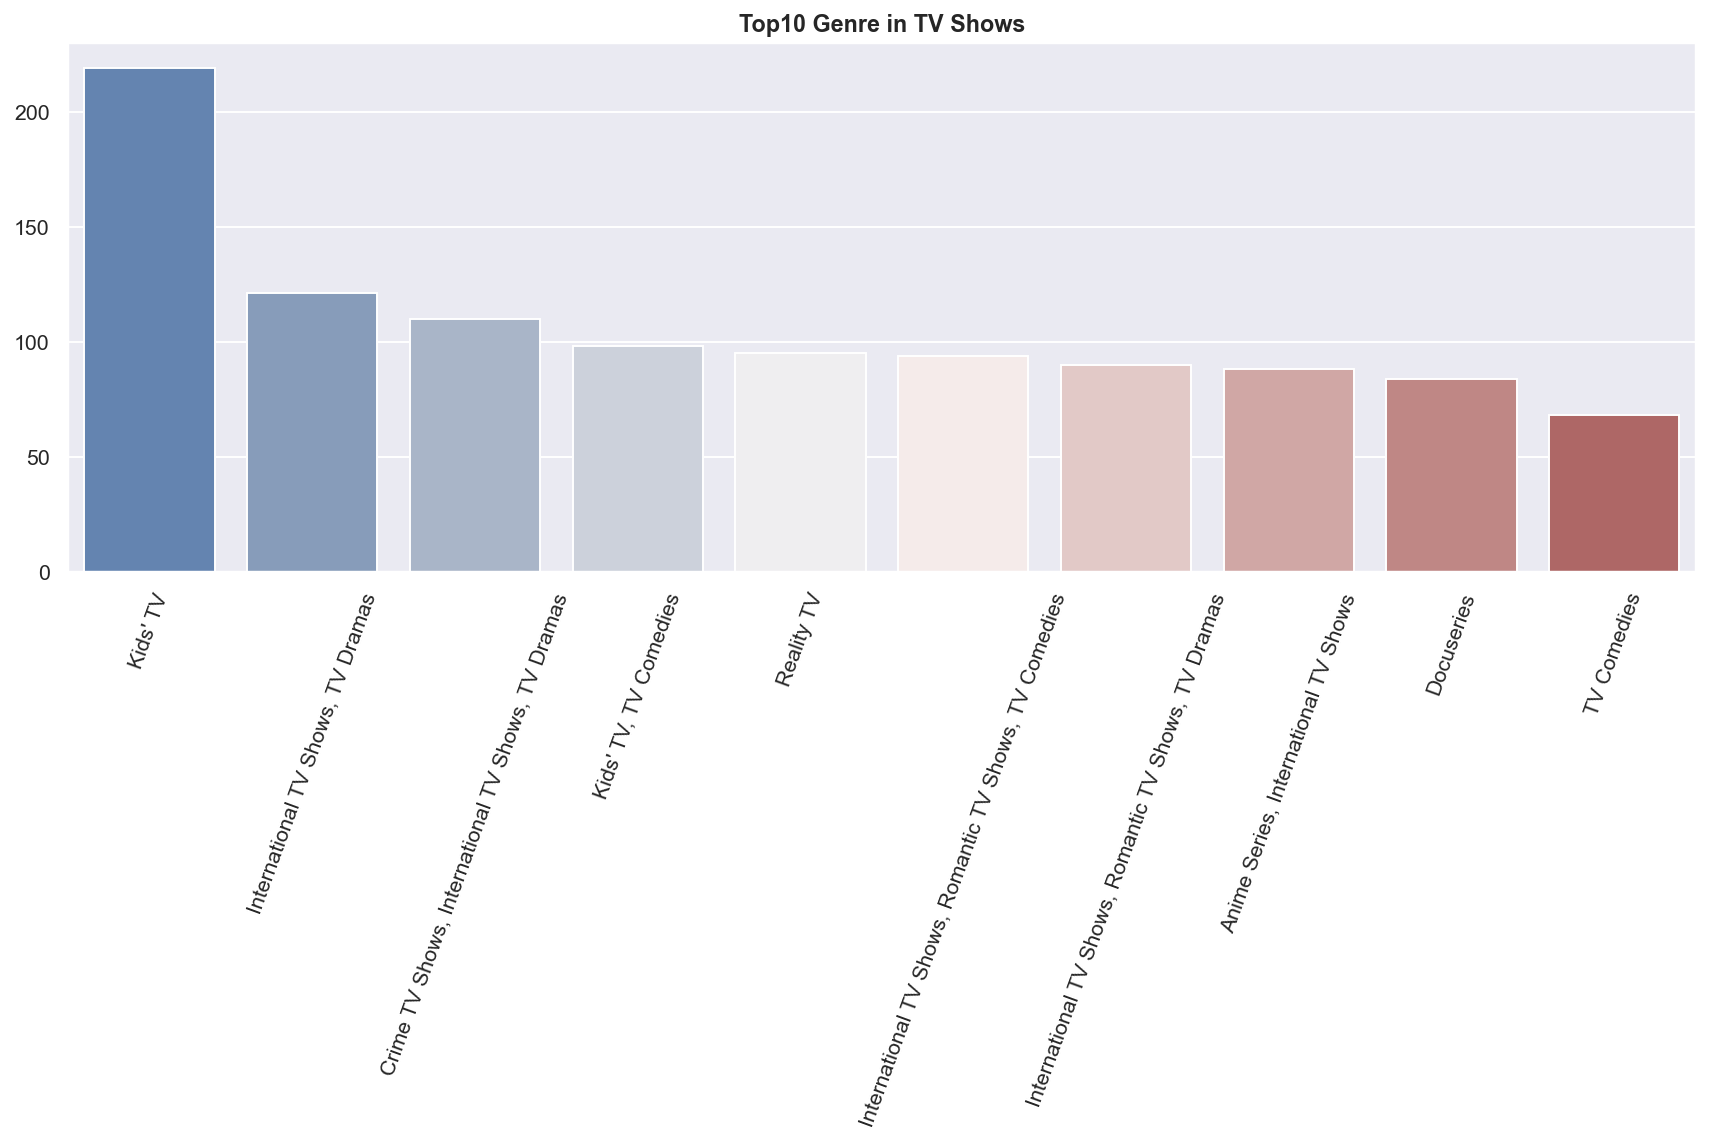

In [25]:
plt.figure(figsize=(15,5))
sns.barplot(x = df_tv["listed_in"].value_counts().head(10).index,
            y = df_tv["listed_in"].value_counts().head(10).values,
            palette="vlag")
plt.xticks(rotation=70)
plt.title("Top10 Genre in TV Shows",fontweight="bold")
plt.show()

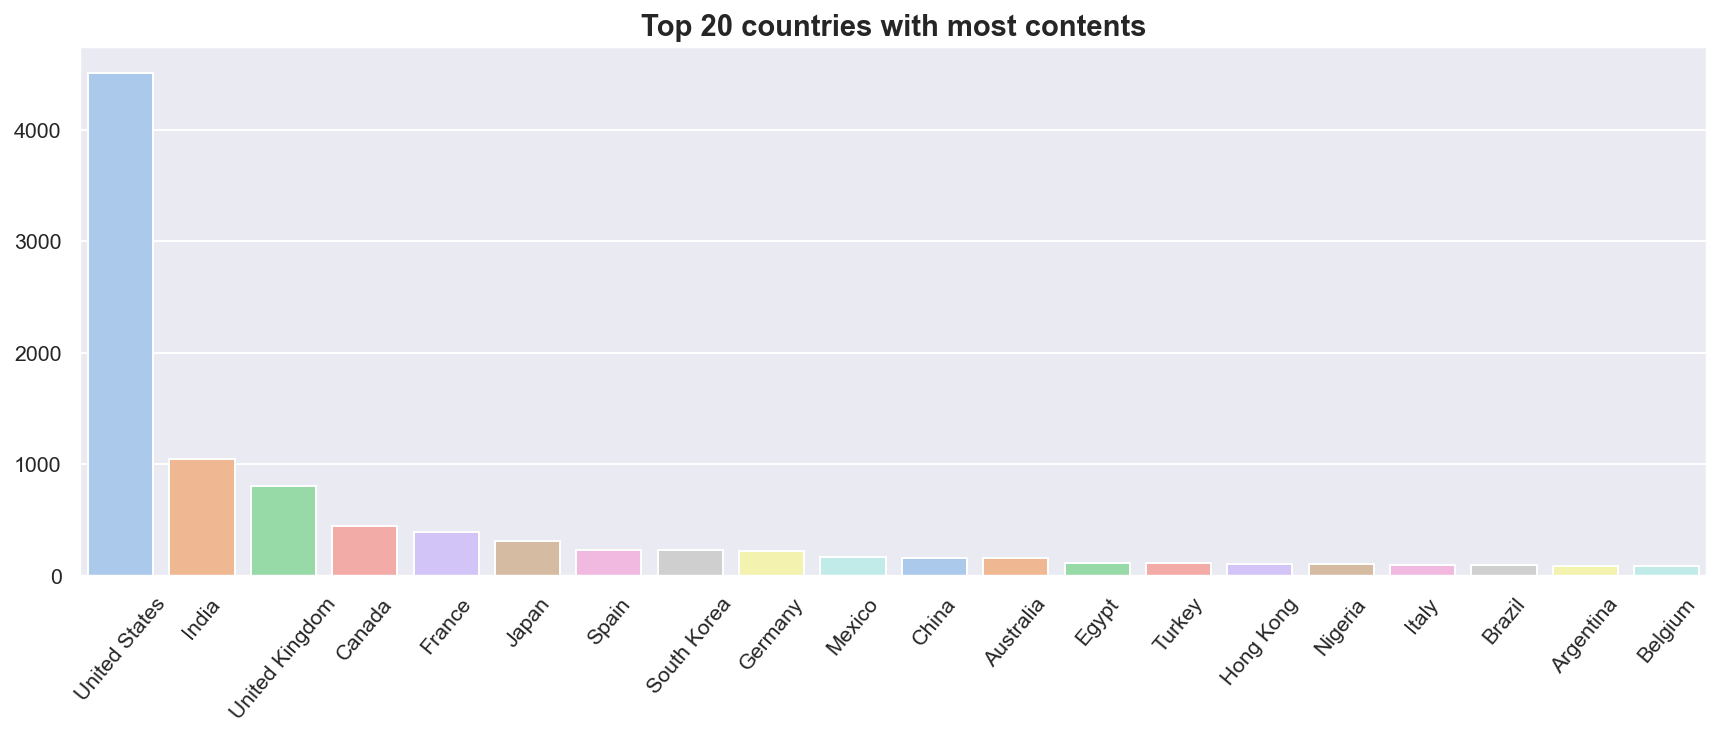

In [26]:
#Top-20 countries producing most contents:

from collections import Counter
country_data = main_df['country']
country_count = pd.Series(dict(Counter(','.join(country_data).replace(' ,',',').replace(
    ', ',',').split(',')))).sort_values(ascending=False)
top20country = country_count.head(20)

plt.figure(figsize=(15,5))
sns.barplot(x= top20country.index, y=top20country, palette="pastel")
plt.xticks(rotation=50)
plt.title('Top 20 countries with most contents', fontsize=15, fontweight='bold')
plt.show()

In [27]:

# Lets retrieve just the first country
main_df['principal_genres'] = main_df['listed_in'].apply(lambda x: x.split(",")[0])
main_df['principal_genres'].head()

0             Documentaries
1    International TV Shows
2            Crime TV Shows
3                Docuseries
4    International TV Shows
Name: principal_genres, dtype: object

In [28]:
#correlation matrix and heat map
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(main_df)
categorical_features

['show_id',
 'type',
 'title',
 'country',
 'date_added',
 'rating',
 'duration',
 'listed_in',
 'description',
 'principal_country',
 'month_added',
 'target_ages',
 'principal_genres']

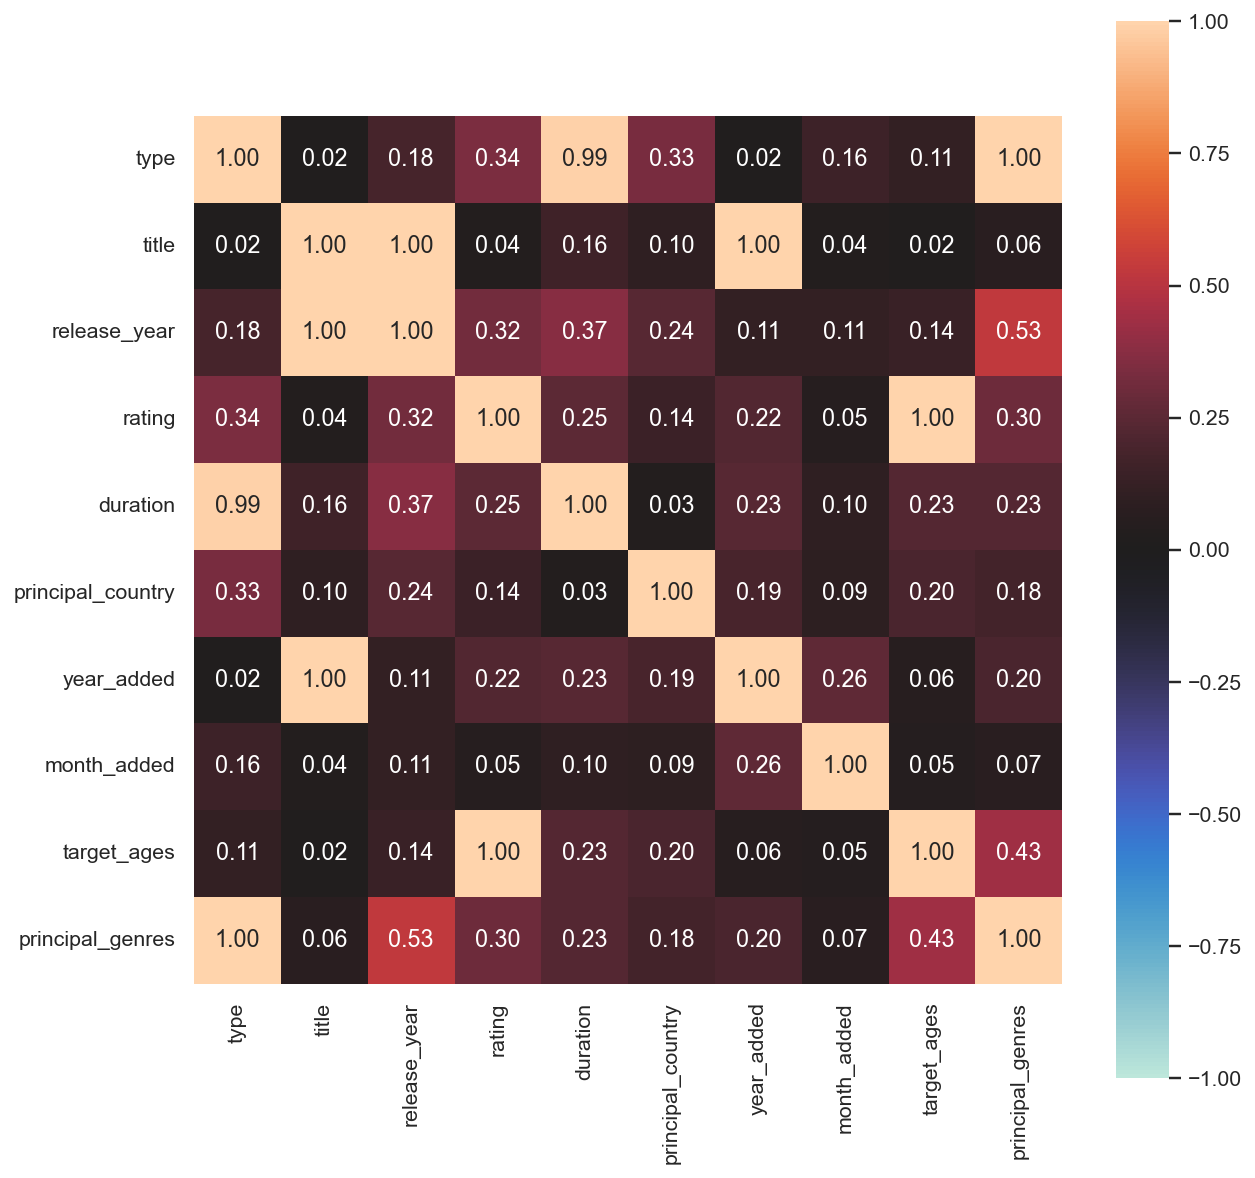

In [29]:

corr_df= main_df.drop(['show_id','country','date_added','description','listed_in'], axis=1)
_DROP_SAMPLES = 'drop_samples'
complete_correlation= associations(corr_df, nan_strategy = _DROP_SAMPLES,
                                   filename= 'complete_correlation.png', figsize=(10,10))

In [30]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, 
                        how='all').dropna(axis=0, 
                                          how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,type,title,release_year,rating,duration,principal_country,year_added,month_added,target_ages,principal_genres
type,1.00,0.02,0.18,0.34,0.99,0.33,0.02,0.16,0.11,1.00
title,0.02,1.00,1.00,0.04,0.16,0.10,1.00,0.04,0.02,0.06
release_year,0.18,1.00,1.00,0.32,0.37,0.24,0.11,0.11,0.14,0.53
rating,0.34,0.04,0.32,1.00,0.25,0.14,0.22,0.05,1.00,0.30
duration,0.99,0.16,0.37,0.25,1.00,0.03,0.23,0.10,0.23,0.23
principal_country,0.33,0.10,0.24,0.14,0.03,1.00,0.19,0.09,0.20,0.18
year_added,0.02,1.00,0.11,0.22,0.23,0.19,1.00,0.26,0.06,0.20
month_added,0.16,0.04,0.11,0.05,0.10,0.09,0.26,1.00,0.05,0.07
target_ages,0.11,0.02,0.14,1.00,0.23,0.20,0.06,0.05,1.00,0.43
principal_genres,1.00,0.06,0.53,0.30,0.23,0.18,0.20,0.07,0.43,1.00


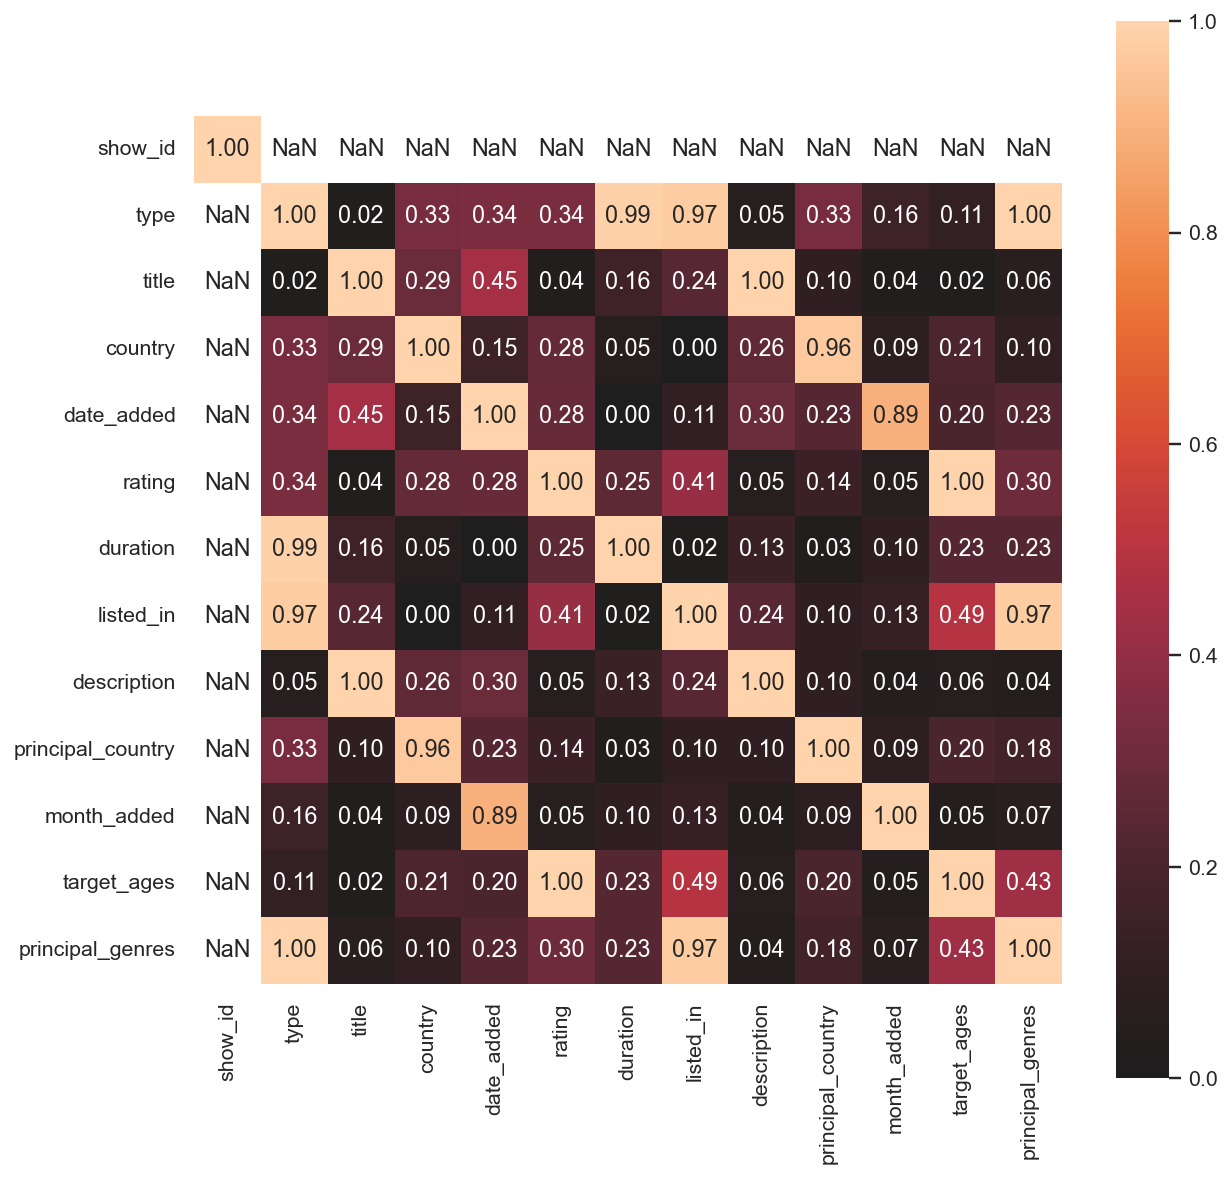

In [31]:
_DROP_SAMPLES = 'drop_samples'
selected_column= main_df[categorical_features]
categorical_df = selected_column.copy()
categorical_correlation= associations(categorical_df, nan_strategy = _DROP_SAMPLES,filename= 'categorical_correlation.png',figsize=(10,10))